# DBSCAN Tutorial

This code is from a YouTube video by Greg Hogg. The link to the video is below:

https://www.youtube.com/watch?v=VO_uzCU_nKw

## Imports

Import the libraries to make a basic DBSCAN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load data

Load the data from california_housing_train.csv

In [2]:
df = pd.read_csv('california_housing_train.csv')
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0    -114.31     34.19                15.0       5612.0          1283.0  \
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
3       515.0       226.0         3.1917             73400.0  
4       624.0       262.0         1.9250             65500.0

## Select features

Using only latitude and longitude so that it is simpler to visualize

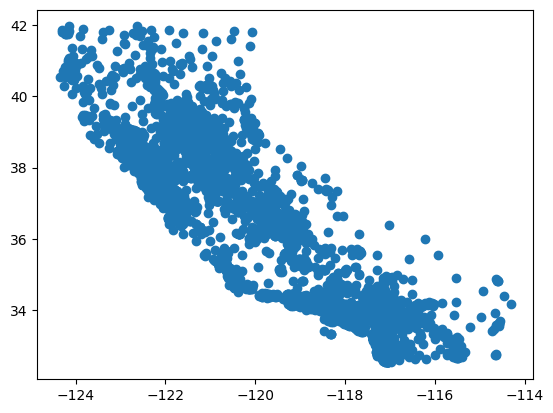

In [3]:
lat_long = df[['latitude','longitude']]
lat,longg = df.latitude, df.longitude

plt.scatter(longg,lat)

## Create DBSCAN

### Convert the Pandas series into a NumPy array

In [4]:
from sklearn.cluster import DBSCAN

X = lat_long.to_numpy()

X.shape

(17000, 2)

### Create a DBSCAN model and fit it to X

In [12]:
dbscan_cluster_model = DBSCAN(eps=0.2,min_samples=15).fit(X)
dbscan_cluster_model

DBSCAN(eps=0.2, min_samples=15)

### Add the cluster labels for the points to the Pandas series

In [13]:
df['cluster'] = dbscan_cluster_model.labels_

df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0    -114.31     34.19                15.0       5612.0          1283.0  \
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  cluster  
0      1015.0       472.0         1.4936             66900.0       -1  
1      1129.0       463.0         1.8200             80100.0       -1  
2       333.0       117.0         1.6509             85700.0       -1  
3       515.0       226.0         3.1917             73400.0       -1  
4       624.0       262.0         1.9250             65500.0       -1

### Count how many points belong to each cluster

Points in -1 cluster are considered noise

In [14]:
df['cluster'].value_counts()

cluster
 2    9065
 4    6999
-1     401
 7     219
 9      95
 0      84
 6      77
 3      21
 5      18
 1      15
 8       6
Name: count, dtype: int64

### Visualize results of DBSCAN

In [15]:
import plotly.express as px

fig = px.scatter(x=longg, y = lat, color=df['cluster'])

fig.show()

### Evaluate accuracy using Silhouette Score

In [16]:
from sklearn.metrics import silhouette_score as ss

ss(X, df['cluster'])

0.257219089938364

## Refine Model

### GridSearch to find best epsilon and min_samples

#### Create a list of possible epsilons (cell radii)

In [17]:
epsilons = np.linspace(0.01, 1, num=15)
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

#### Create a list of possible min_samples

min_samples is the number of surrounding points required for a point to be considered a "core point"

In [18]:
min_samples = np.arange(2, 20, step=3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

#### Create all possible combinations using values from epsilons and min_samples arrays

In [23]:
import itertools

combinations = list(itertools.product(epsilons,min_samples))
combinations[:5]


[(0.01, 2), (0.01, 5), (0.01, 8), (0.01, 11), (0.01, 14)]

There will be a total of N combinations

In [22]:
N = len(combinations)
N

90

### Function to determine best parameters for dbscan

In [35]:
def get_scores_and_labels(combinations, X):
    # Create empty lists to store results
    scores = []
    all_labels_list = []
    
    # Loop through all possible DBSCANs
    for i, (eps, num_samples) in enumerate(combinations):
        # Make a new model with parameters
        dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        
        # Determine label
        labels = dbscan_cluster_model.labels_
        labels_set = set(labels)
        
        # Determine number of clusters in the model
        num_clusters = len(labels_set)
        
        # Reduce the number of cluster by one if noise is included
        if -1 in labels_set:
            num_clusters -= 1
        
        # If the number of clusters is unreasonable, append a junk value
        if (num_clusters<2) or (num_clusters>50):
            scores.append(-10)
            all_labels_list.append('bad')
            continue
            
        # Add the score and label to the predefined arrays
        scores.append(ss(X,labels))
        all_labels_list.append(labels)
        
    # Determine the index with the best result and find the best values
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]
    
    # Return a dictionary with the best parameters
    return {'best_epsilon':best_parameters[0],
            'best_min_samples':best_parameters[1],
            'best_labels':best_labels,
            'best_score':best_score}

#### Get the best parameters by using the function

In [36]:
best_dict = get_scores_and_labels(combinations,X)

In [37]:
best_dict

{'best_epsilon': 0.29285714285714287,
 'best_min_samples': 14,
 'best_labels': array([-1, -1, -1, ..., -1, -1,  4], dtype=int64),
 'best_score': 0.4066290757338105}

#### Update the clusters to use the best labels as found by the function

In [38]:
df['cluster'] = best_dict['best_labels']

df['cluster'].value_counts()

cluster
 0    9417
 2    7221
-1     202
 4     103
 3      35
 1      22
Name: count, dtype: int64

### Visualize new model

In [39]:
fig = px.scatter(x=longg, y = lat, color=df['cluster'])
fig.show()

## Importance of scaling data

### Without Scaling

#### Plot values of two sets with significantly different ranges

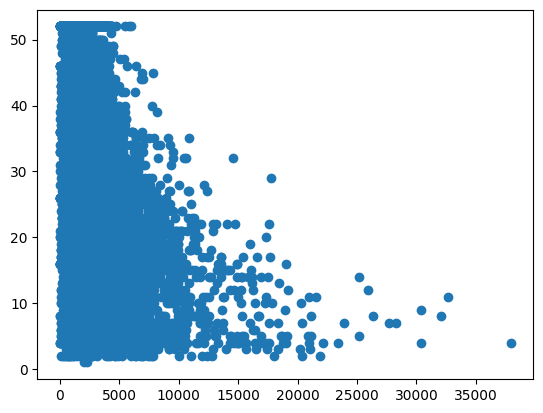

In [40]:
plt.scatter(df.total_rooms,df.housing_median_age)

#### Create a NumPy array holding values for rooms and age

In [41]:
X2 = df[['total_rooms','housing_median_age']].to_numpy()

#### Determine the best parameters using the function

In [42]:
best_dict2 = get_scores_and_labels(combinations,X2)

#### Display the results

In [43]:
best_dict2

{'best_epsilon': 0.01,
 'best_min_samples': 2,
 'best_labels': 'bad',
 'best_score': -10}

### Scale values to reduce one parameter dominating results

#### Use StandardScaler to transform the dataset and plot the result

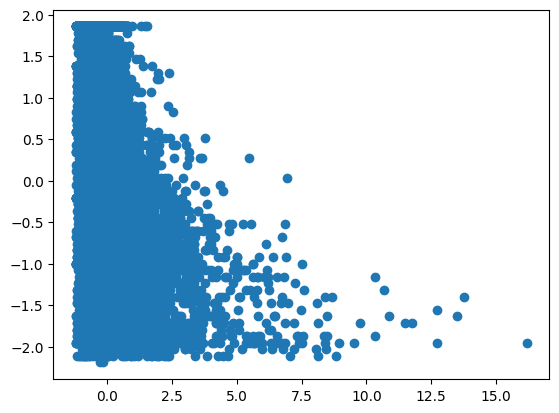

In [45]:
from sklearn.preprocessing import StandardScaler

X2_scaled = StandardScaler().fit_transform(X2)

plt.scatter(X2_scaled[:,0], X2_scaled[:,1])

#### Get the best parameters using the function described

In [47]:
best_dict3 = get_scores_and_labels(combinations,X2_scaled)

#### Display the results of running the function

In [48]:
best_dict3

{'best_epsilon': 0.8585714285714285,
 'best_min_samples': 2,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'best_score': 0.8739122955987667}

#### Plot the new clusters

In [50]:
fig = px.scatter(x=X2_scaled[:,0],y=X2_scaled[:,1],color = best_dict3['best_labels'])
fig.show()